In [154]:
import numpy as np
import pandas as pd

import os
import glob

import joypy

In [155]:
# %matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue'], 
                 'serif': ['Helvetica Neue']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Generate plots of gating effects

In [156]:
test = pd.read_csv(r'Z:\Reed\Projects\micro_consortia\DARPA_biocon\Task 1.1\A=B\20181009 top 4 AB vars A=B 1\flow\23hr\C4.csv')
test.columns

Index(['HDR-T', 'FSC-A', 'SSC-A', 'CFP/VioBlue-A', 'PE-A', 'mKate/APC-A',
       'GFP/FITC-A', 'AH_perc_gate', 'mKate/APC-A_GMMgate'],
      dtype='object')

C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


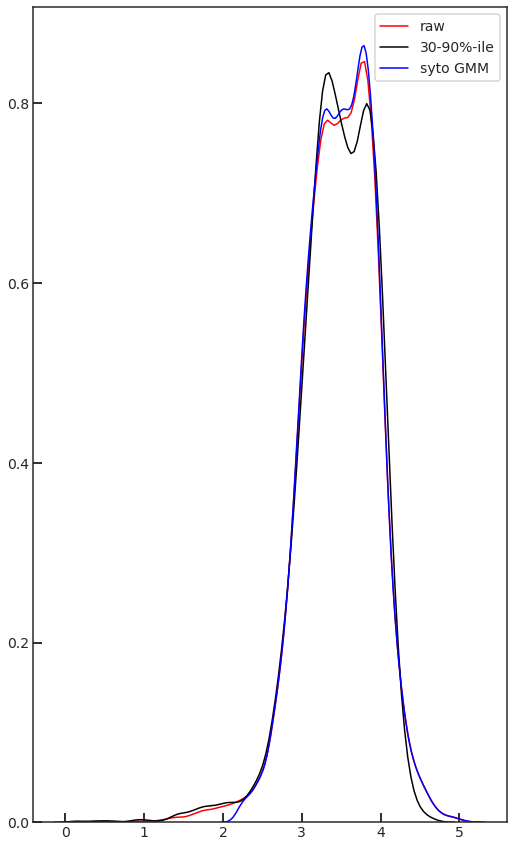

In [157]:
sns.kdeplot(test.loc[:, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['AH_perc_gate'] == 1, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['mKate/APC-A_GMMgate'] == 1, 'mKate/APC-A'].apply(np.log10))

plt.legend(labels=['raw', '30-90%-ile', 'syto GMM'])

### This is a work in progress, wanted to check first to see what we got and then move forward with analysis

## Plot fractions on and off in YFP channel over time

In [158]:
first = [i+j for i in ['A', 'B', 'C'] for j in ['1','2','3', '4', '5', '6', '7', '8', '9']]
second = [i+j for i in ['D', 'E', 'F', 'G', 'H'] for j in ['1','2','3', '4', '5', '6', '7', '8']]

#these are the only ones that all 4 tpts have in common due to incomplete 0hr sampling
wells_10 = first + second


#all 96 wells (common for 7, 19, 23 time points)
wells = [i+j for i in ['A','B','C','D','E','F','G','H'] for j in ['1','2','3','4','5','6','7','8','9','10','11','12']]

In [159]:
tpts = [0, 7, 19, 23]
t_last3 = [7, 19, 23]

In [160]:
gates = ['mKate/APC-A_GMMgate', 'AH_perc_gate']

In [161]:
def get_ratios_fracs (timepoints, well, gate):
    """
    gets the A:B ratio for each time point for a particular well, using the GMM analyzed data csv you made with
    Andy's analysis script.
    
    the timepoints argument is involved in making the filename to open, so if the location of your analyzed data
    changes, you'll need to edit this function
    """
    
    ratios = []
    f_ons = []
    f_offs = []
    for tpt in timepoints:
        
        directory = 'Z:/Reed/Projects/micro_consortia/DARPA_biocon/Task 1.1/A=B/20181009 top 4 AB vars A=B 1/flow/'
        
        ana = pd.read_csv(directory + str(tpt) + 'hr/' + str(tpt) + 'hr_yfp_GMManalysis.csv')

        one = ana['well'] == well

        two = ana['gate'] == gate

        info = ana.loc[one & two, :]

        #OFF cells are A (BFP+), ON cells are B(YFP+). This division is A:B ratio
        ratio = info['fraction OFF'] / info['fraction ON']
        
        #let's also just get the fractions themselves
        frac_on = info['fraction ON']
        frac_off = info['fraction OFF']

        ratios.append(ratio.values[0])
        f_ons.append(frac_on.values[0])
        f_offs.append(frac_off.values[0])

    rs = pd.Series(data=ratios, index=timepoints, name='ratio')
    fons = pd.Series(data=f_ons, index=timepoints, name='frac_on')
    foffs = pd.Series(data=f_offs, index=timepoints, name='frac_off')
    
    #this has got to be the most convoluted way to create this df, but I'm committed
    #and don't understand enough to do it a better way
    df_collection = (pd.DataFrame([rs, fons, foffs]).assign(well=well)
                     .reset_index()
                     .rename(columns = {'index' : 'type'})
                    )
    
    
    
    return df_collection

In [162]:
def tidy_ratios (timepoints, wells_list, gate):
    
    #transpose so each well is a column rather than a row
    all_ratios = pd.concat([get_ratios_fracs(timepoints, w, gate) for w in wells_list])
    
    #melt it tidy
    all_ratios = pd.melt(all_ratios, id_vars=['well', 'type'], value_vars=[0, 7, 19, 23], var_name='Time (hr)')
    
    return all_ratios.sort_values(by=['well', 'type'])

In [165]:
def add_id_info (data_sheet_melted, df_id):
    
    #make a copy of the dataframe so you can return the new one and set whatever name you want
    df = data_sheet_melted.copy()

    #initialize the columns to be used to store ID info
    all_id_columns = [col for col in df_id.columns if col not in 'well']

    for c in all_id_columns:
        df[c] = np.nan

    #get the list of all the wells you want to annotate (which are the ones in the data)
    wells = np.unique(df['well'])

    #loop over these wells and add the information to the initialized columns
    for w in wells:
        #get the ID information for this well
        append_this = df_id.loc[df_id['well'] == w, :]

        #loop over each column containing a unique piece of ID info
        for c in all_id_columns:

            #set the value for that column for that well
            df.loc[df['well'] == w, c] = append_this[c].values
                                                                #have to use .values otherwise index carries along and only
                                                                #sets the value for the data table index equal to the
                                                                #id table index

    return df

In [166]:
all_ratios = tidy_ratios(tpts, wells_10, gates[0])

In [167]:
df_id = pd.read_excel('Z:/Reed/Projects/micro_consortia/DARPA_biocon/Task 1.1/A=B/20181009 top 4 AB vars A=B 1/20181009 top 4 A B cell variants A=B sampling exp 1.xlsx',
                      sheet_name='IDs')

In [168]:
#want to add all the important well ID information
all_ratios = add_id_info(all_ratios, df_id)

### actually make the plots

In [169]:
#create a column I can use facetgrid to hue on
all_ratios = all_ratios.assign(ab_id = all_ratios['a'].astype(str) + all_ratios['b'].astype(str))

#remove the non mixed singe cell populations
idx1 = all_ratios['ba ratio'] == 10

#exclude the final half induced wells
idx2 = ~((all_ratios['atc'] == 0) & (all_ratios['iptg'] == 1))

#I just want to plot fractions
idx3 = all_ratios['type'] != 'ratio'

#composite index

i = idx1 & idx2 & idx3

In [170]:
all_ratios.loc[i].head()

,well,type,Time (hr),value,a,b,ba ratio,atc,iptg,ab_id
26,A9,frac_off,0,0.75536,51.0,11.0,10,351.0,1.0,51.011.0
227,A9,frac_off,7,0.00000,51.0,11.0,10,351.0,1.0,51.011.0
428,A9,frac_off,19,0.00000,51.0,11.0,10,351.0,1.0,51.011.0
629,A9,frac_off,23,0.00000,51.0,11.0,10,351.0,1.0,51.011.0
25,A9,frac_on,0,0.24464,51.0,11.0,10,351.0,1.0,51.011.0


In [171]:
def onoffplot_df (x, y, **kwargs):
    
    ax = plt.gca()
    data = kwargs.pop("data")
    c = kwargs.pop("color")
    
    #lets just plot the fraction that's YFP+ (B cells)
    b_idx = data['type'] == 'frac_on'
    
    #get the ON values
    on = data['iptg'] == 1
    
    on_index = on & b_idx
    
    sns.pointplot(x=x, y=y, data=data.loc[on_index], ax=ax, hue='type', linestyles='-', color=c, errwidth=1.2)
#     data.loc[on_idx].plot(x=x, y=y, ax=ax, grid=False, linestyle='-', **kwargs)
    
    #get the OFF values
    off_index = [not x for x in on] & b_idx
    
    sns.pointplot(x=x, y=y, data=data.loc[off_index], ax=ax, hue='type', linestyles='--', color=c, errwidth=1.2)
#     data.loc[off_idx].plot(x=x, y=y, ax=ax, grid=False, linestyle='--', **kwargs)

In [172]:
def fix_title (axes_obj):
    
    title_str = axes_obj.title.get_text()
    
    title_str = title_str.replace('0', '').split('.')
    
    new_title = 'A' + title_str[0] + ' + ' + 'B' + title_str[1]
    
    return new_title

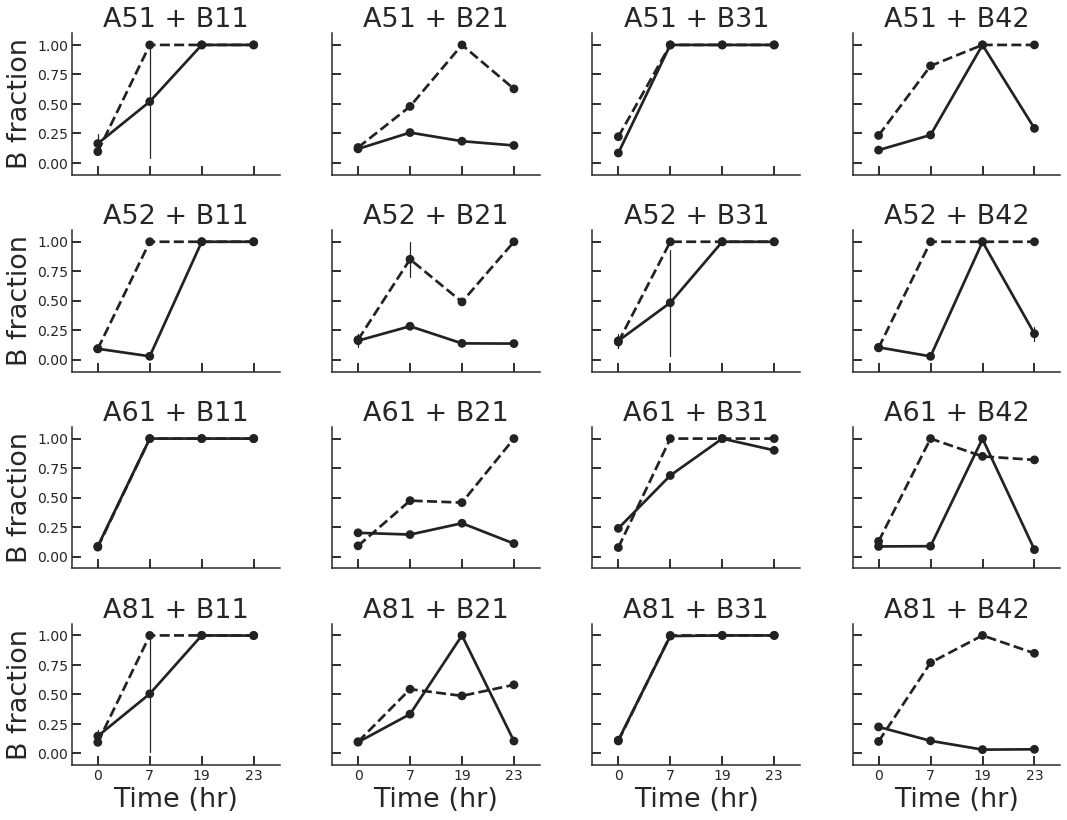

In [173]:
# pal = dict(frac_on="#EDB65F", frac_off='#07659B')

#try sorting the data to get a useful ordering of axes in the facetgrid

dt = all_ratios.loc[i].sort_values(by=['a', 'b'])

#creat the desired grid
g = sns.FacetGrid(dt, col="ab_id",
                  col_wrap=4, height=3, aspect=1.3, ylim=(-0.1,1.1), margin_titles=True)


#add the lines to the plots using custom defined function above
g.map_dataframe(onoffplot_df, "Time (hr)", "value", color = 'dimgray')

#formatting
g.set_titles("{col_name}")
g.set_axis_labels('Time (hr)', "B fraction")

#fix the titles
axes = g.axes.flatten()

for ax in axes:
    ax.title.set_text(fix_title(ax))

In [174]:
# g.savefig('Z:/Reed/Projects/micro_consortia/DARPA_biocon/Task 1.1/A=B/20181009 top 4 AB vars A=B 1/flow/figs/Bfracs_time_sytoGMMgate.pdf')

## Joyplots of the raw data

In [67]:
def raw_data_over_tpts (timepoints, well, gate, channel):
    
    all_data = pd.DataFrame()
    
    for tpt in timepoints:
        data = pd.read_csv('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/' + str(tpt) + 'hr/' + well + '.csv')
        
        gated = data.loc[data[gate] == 1, :]
        
        log_gate = (gated[channel].apply(np.log10)
                    .dropna() #drop the nans produced by negative inputs to log10
                    .reset_index(drop=True) #indices in different tpts will be different, makes ugly final df
                    .rename(str(tpt) + 'hr') #want the column name in final df to be the axis label in joyplot
                   )
        
        #concat them side by side
        all_data = pd.concat([all_data, log_gate], axis=1)
        
    return all_data
        

In [68]:
first = [i+j for i in ['A', 'B', 'C'] for j in ['1','2','3', '4', '5', '6', '7', '8', '9']]
second = [i+j for i in ['D', 'E', 'F', 'G', 'H'] for j in ['1','2','3', '4', '5', '6', '7', '8']]

#these are the only ones that all 4 tpts have in common due to incomplete 0hr sampling
wells_10 = first + second


#all 96 wells (common for 7, 19, 23 time points)
wells = [i+j for i in ['A','B','C','D','E','F','G','H'] for j in ['1','2','3','4','5','6','7','8','9','10','11','12']]

In [69]:
tpts = [0, 7, 19, 23]
t_last3 = [7, 19, 23]

gates = ['mKate/APC-A_GMMgate', 'AH_perc_gate']

In [70]:
well = 'H2'

gg = raw_data_over_tpts(tpts, well, gates[0], 'GFP/FITC-A')

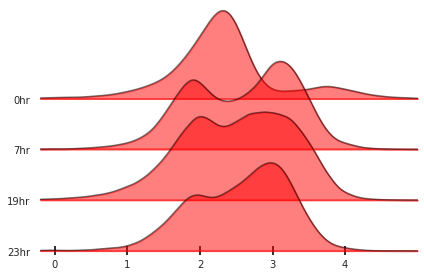

In [75]:
fig, axes = joypy.joyplot(gg, ylim='own', x_range=(-0.2,5), alpha=0.5)

In [42]:
help(dict.get)

Help on method_descriptor:

get(...)
    D.get(k[,d]) -> D[k] if k in D, else d.  d defaults to None.

